In [1]:
#《Py神经网络编程》塔里克·拉希德，人民邮电出版社，出版时间2018-04，第2章第4节编程实例
# zpf2617，测试环境anaconda base Python 3.9.13
#2022.10.26测试，测试原代码地址：https://github.com/zpf2617
#感谢这本书让我这个0基础的人从头手撸了一个神经网络！感谢作者！感谢微信读书让我免费读了这本书！新疆库尔勒疫情期间无聊的生活里的一点小乐趣，希望自己能扛过去，希望家人健康平安，媳妇早早回家
#MNIST数据集的下载地址：https://pjreddie.com/projects/mnist-in-csv/,原书源代码：https://github.com/makeyourownneuralnetwork
##增加世代，重复训练，可以减小训练样本数量，提高计算准确率，比如循环训练训练样本5遍，训练太多遍会过度拟合，只对特定样本敏感epochs=5
#所有可以修改和应该修改的变量：所有路径（权重保存和读取最好默认）、170行epochs训练循环次数、151行hidden_nodes隐藏层节点数量、
#、157行learning_rate学习率、252行label标签（0~9)，MNIST.csv自行下载，第一列是标签，2~785是样本数据
#新手0基础学习，有问题多多指教！
import numpy    #生成矩阵、数组、整体分布、随机数
import scipy    #sigmoid激活函数
import pandas as pd     ##pandas保存权重
import matplotlib.pyplot
# 装饰器，语法糖，确保图形显示在编辑器里面，不会单独弹出窗口
%matplotlib inline
#神经网络类定义
class neuralNetwork:
    #三层神经网络(输入、隐藏、输出)结构
    #初始化神经网络
    def __init__(self,inputnodes,hiddennodes,outputnodes,learningrate):
        self.inodes=inputnodes  #输入层节点数量
        self.hnodes=hiddennodes  #隐藏层节点数量
        self.onodes=outputnodes  #输出层节点数量
        self.lr=learningrate  #学习率

        #链接权重矩阵，wih 和 who ,weight input hidden   and  weight hidden output
        #节点 i 到 节点 j（下一层）之间的链接用数组里的权重 w_i_j表示，比如w11 w21 w12 w22 等等。
        #链接权重矩阵初始化方式（1）（2）两种任选其一

        #链接权重矩阵初始化方式（1）：平均随机采样，
        self.wih=numpy.random.rand(self.hnodes,self.inodes)-0.5     #输入节点隐藏节点权重矩阵，随机数0-1之间，权重数值在（-0.5 至0.5)之间
        self.who=numpy.random.rand(self.onodes,self.hnodes)-0.5     #隐藏节点输出节点权重矩阵，随机数0-1之间，权重数值在（-0.5 至0.5)之间

        #链接权重矩阵初始化方式（2）：正态分布随机采样，【1/根号下(传入连接数目)】。参考分布中心值，标准方差，数组大小（12572640）
        # self.wih=numpy.random.normal(0.0,pow(self.hnodes,-0.5),(self.hnodes,self.inodes))       #输入节点隐藏节点权重矩阵，pow:节点数目的-0.5次方，中心点0.0，标准方差，数组大小
        # self.who=numpy.random.normal(0.0,pow(self.hnodes,-0.5),(self.onodes,self.hnodes))       #隐藏节点输出节点权重矩阵，pow:节点数目的-0.5次方，中心点0.0，标准方差，数组大小

        #sigmoid激活函数,定义
        self.activation_function=lambda x: scipy.special.expit(x)       #scipy.special.expit(x)=sigmoid(x)激活函数，lambda 匿名函数，接受x并返回处理结果
        self.inverse_activation_function = lambda x: scipy.special.logit(x)     #反向激活函数，  y=f(x),现在x=F(y)

    #训练神经网络
    def train(self,inputs_list,targets_list):
        #第一部分：针对训练样本计算输出
        #第二部分：计算输出结果和给定目标结果差值返回更新网络权重，反向传播
        
        #把输入inputs信号,targets(给定的，人判断出来的，准确的）目标列表list转换成2维数组array
        inputs=numpy.array(inputs_list,ndmin=2).T
        targets=numpy.array(targets_list,ndmin=2).T

        #信号从输入传至输出。。。。         和query()里面市一样的
        #计算隐藏层节点输入信号=输入隐藏层节点权重 点乘dot 输入信号 
        hidden_inputs=numpy.dot(self.wih,inputs)
        #隐藏层输出信号=激活函数（隐藏层节点输入信号）
        hidden_outputs=self.activation_function(hidden_inputs)
        #输出层节点输入信号=输出隐藏层节点权重 点乘dot 隐藏层输出信号
        final_inputs=numpy.dot(self.who,hidden_outputs)
        #输出层节点输出信号=激活函数（输出层节点输入信号）
        final_outputs=self.activation_function(final_inputs)

        #计算误差：（输出层输出信号）误差=目标值-计算值
        #目标值(给定的，人判断出来的，准确的，预期目标值）-计算值（机器用随机权重网络算的，有误差不准确的，随机猜数字，如果跟结果不对，更新计算方法，直到计算接近正确）
        output_errors=targets-final_outputs

        #误差分割原理，按比例分割，不涉及激活函数问题，隐藏层输出信号的误差=输出层输出信号误差/权重，比如权重大的贡献的误差也大，多少权重贡献多少误差，分割，求和得到总误差
        hidden_errors=numpy.dot(self.who.T,output_errors)

        #权重更新矩阵，反向传播关键步骤,应用梯度下降法,推导过程如下
        #其中：final_outputs*(1.0-final_outputs) ->激活函数simoid(x)求导simoid(x)*(1-simoid(x))
        #simoid(x)=final_outputs,即激活函数sigmoid(输出层输入信号final_inputs)=final_outputs,如f(x)=y
        #微积分德尔塔△表示微小变化，则：梯度下降原理
        # （1）权重+=权重的变化   等于   权重=权重+权重的变化
        #  (2)权重的变化 = 学习率(控制步长，避免超调) * 输出层输出信号的变化（输出层输出信号对权重w求导) ÷ 隐藏层输出信号（矩阵转置表除法÷）
        #   既：Who△=lr*Fin△ ÷ Hout，权重变化=（输出误差/输入信号（隐藏层的输出信号））*误差函数对权重的求导叫做变化
        #   既：输出△=输入*权重△      输入信号*权重变化=输出变化    ，权重求和问题由矩阵完成，不必细分
        #隐藏节点输出节点权重矩阵更新
        self.who+=self.lr * numpy.dot(output_errors*final_outputs*(1.0-final_outputs),numpy.transpose(hidden_outputs))

        #输入节点隐藏节点权重矩阵更新
        self.wih+=self.lr * numpy.dot(hidden_errors*hidden_outputs*(1-hidden_outputs),numpy.transpose(inputs))

    #查询神经网络
    def query(self,inputs_list):

        #把输入inputs信号列表list转换成2维数组array
        inputs=numpy.array(inputs_list,ndmin=2).T

        #信号从输入传至输出。。。。
        #计算隐藏层节点输入信号=输入隐藏层节点权重 点乘dot 输入信号 
        hidden_inputs=numpy.dot(self.wih,inputs)
        #隐藏层输出信号=激活函数（隐藏层节点输入信号）
        hidden_outputs=self.activation_function(hidden_inputs)
        #输出层节点输入信号=输出隐藏层节点权重 点乘dot 隐藏层输出信号
        final_inputs=numpy.dot(self.who,hidden_outputs)
        #输出层节点输出信号=激活函数（输出层节点输入信号）
        final_outputs=self.activation_function(final_inputs)

        #返回输出层节点输出信号
        return final_outputs
        pass

    # 反向查询神经网络
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # 把列表数据转换成用于计算的numpy数组
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # 输出层输入信号=反向激活函数（输出层输出信号）
        final_inputs = self.inverse_activation_function(final_outputs)

        # 隐藏层输出=输出层输入/隐藏节点输出节点权重矩阵   逆矩阵.T = ÷
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # 反向归一化大致
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)     #举例：[2,5,9]-2=[0,3,7]
        hidden_outputs /= numpy.max(hidden_outputs)     #举例：[0,3,7]/7 =[0,3/7,1]
        hidden_outputs *= 0.98      #举例[0,3/7,1]*0.98  =[0,0.42,0.98]
        hidden_outputs += 0.01      #举例[0,0.42,0.98]+0.01= [0.01,0.43,0.99]
        
        # 隐藏层输入=反向激活函数（隐藏层输出信号）
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # 输入层输出=输入=隐藏层输入/输入节点隐藏节点权重矩阵
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

# #定义输入层、隐藏层、输出层节点数量,学习率
# input_nodes=784
# hidden_nodes=100
# output_nodes=3
# learning_rate=0.3

# #创建神经网络实例
# n=neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)
# inputlist=[1.0,0.5,-1.5]
# n.query(inputlist)

# 进行MNIST的神经网络训练
# 输入层有784个变量（28*28个像素点）
input_nodes = 784
# 隐藏层有200个变量（这个由自己定）
hidden_nodes = 200
# 输出层有10个变量（10个数字）
output_nodes = 10
# 学习率为0.1、0.3
learning_rate = 0.1
# 搭建一个神经网络
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)
#开始训练
training_data_file = open("C:/mnist_train_60000.csv",'r')
# C:/myMNIST.csv,读取训练样本
# training_data_file = open("C:/myMNIST_train.csv",'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

i = 1
#增加世代，重复训练，比如循环训练训练样本5遍，训练太多遍会过度拟合，只对特定样本敏感
epochs=0
for e in range(epochs):
# 训练数据集，共计785列数据，第一列是目标值0~9  ->all_values[0]，第2至785列->all_values[1:]  共计784=28*28个0~255灰度值。
    for record in training_data_list:

        # 把每一个record都用逗号隔开
        all_values = record.split(',')
        # 将颜色代码用0~1归一化
        inputs = (numpy.asfarray(all_values[1:])/255.0*0.99)+0.01       #归0~1，然后0.01~0.99,确保输入不等于0，#numpy.asfarray功能列表转化为浮点数数组，整数加个1.0变浮点数.
        targets = numpy.zeros(output_nodes) + 0.01      #numpy.zeros功能为0.0的数组1行10列（output_nodes输出节点），然后每个元素加0.01
        #数据第一列标签0~9,10，数据第一列标签0~9,10列的一维数组的第0~9个数据等于0.99，其余是0.01，例如标签4， targets=[0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01]
        targets[int(all_values[0])] = 0.99
        # 给定目标，让神经网络学习。
        n.train(inputs,targets)
        pass
        #打印i可以看到运行进度，不然黑乎乎的，训练等的太着急
        print(i)
        i += 1
    pass

#训练完保存权重,如果训练循环（世代）等于0，则不训练，直接读取前一次训练的结果，如果不等于0，则保存训练结果的权重
#权重固定，测试结果就固定了
pass
if epochs == 0:
    df_wih_r=pd.read_csv("df_wih.csv",header=None,index_col=0)  #header=None，不是header=0，否则会把第一行当成表头，数据少了1行，
    df_who_r=pd.read_csv("df_who.csv",header=None,index_col=0)  #index_col=0，索引设置在第一列，否则读取的结果会多1列索引，数组大小就不一样了
    n.wih=df_wih_r.to_numpy()
    n.who=df_who_r.to_numpy()
#     print("epochs=0",epochs)
else:    
    df_wih=pd.DataFrame(n.wih)
    df_who=pd.DataFrame(n.who)
    df_wih.to_csv("df_wih.csv",header=None)
    df_who.to_csv("df_who.csv",header=None)

print("epochs",epochs)

# 开始测试，检验神经网络编程训练的结果是否准确
#读取测试样本
testing_data_file = open("C:/mnist_test_10000.csv",'r')
# testing_data_file = open("C:/myMNIST_test.csv",'r')
testing_data_list = testing_data_file.readlines()
testing_data_file.close()

#测试成绩得分列表
score_card = []
j = 1
# 循环结构
for record in testing_data_list:
    # 把每一个record都用逗号隔开
    all_values = record.split(',')
    # 将颜色代码用0~1归一化
    correct_label = int(all_values[0])
    # 测试这个数据集应该对应着哪一个数
    inputs = (numpy.asfarray(all_values[1:])/255.0*0.99)+0.01
    outputs = n.query(inputs)
    # 选择特征值最大的数字
    label = numpy.argmax(outputs)
    # 计算得分，计算结果和目标一直加1分，否则不得分。
    if label == correct_label:
        score_card.append(1)
    else:
        score_card.append(0)
        print("计算错误的测试样本是第  :",j," 个，目标",correct_label,",计算结果",label)
    # print(j)
    j += 1

# 看看最后得到了多少分，并求出其百分比。
#200个训练样本，识别准确率大概60%左右，10000个样本准确率大概90%左右，60000个MNIST样本5个epochs训练循环准确率大概97，概率的不确定性跟权重初始值和网络结构有关

score_card_array = numpy.asarray(score_card)
print(f"重复%-6.4d代训练"%(epochs),end="****\n\n")
print('performance =',score_card_array.sum()/score_card_array.size)

# run the network backwards, given a label, see what image it produces
#设置目标标签开始测试向后查询
label = 2
# 创建输出目标信号，第N列=0.99，其他没信号的给一个0.01，不用0防止训练进入死去，0乘任何数字等于0
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# 反向查询函数，输入目标值，得到神经网络输入图像数据，10个节点-隐藏节点-输出784个节点一行数据，一维数组，后期可以卷积，考虑图像的二维属性
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')
#


FileNotFoundError: [Errno 2] No such file or directory: 'df_wih.csv'

样本模板： 0


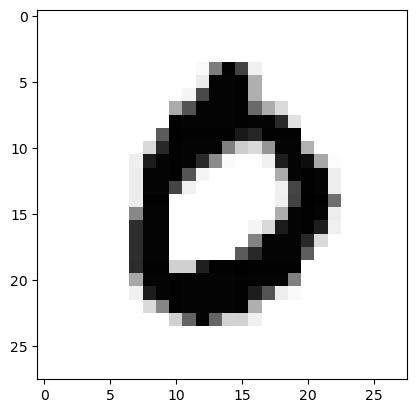

In [2]:
#把MNIST数据csv格式绘制成图片，方便目测检查结果
import numpy
import matplotlib.pyplot    #把csv格式的MNIST数据显示出来
# import maplotlib.pyplot
#装饰器，只用matplotlib.pyplot 绘图，装饰器后面不能加注释
%matplotlib inline  

#一次性读取文件
data_file = open("C:/mnist_test_100.csv",'r')

# data_file = open("C:/myMNIST.csv",'r')    #自建的MNIST样本
data_list = data_file.readlines()
data_file.close()
#数据集第n条数据（从1开始）第n行

#调整这个行数来显示
n=4

all_values=data_list[n-1].split(",")
image_array=numpy.asfarray(all_values[1:]).reshape(28,28)
matplotlib.pyplot.imshow(image_array,cmap="Greys",interpolation='None')

print("样本模板：",all_values[0])

In [2]:
#生成自己的MNIST验证样本数据
#1首先准备图片，在photoshop里面新建保存28*28像素的JPG白底黑字jPG格式，surface pen手写数字，可以用动作录制更快，放在一个文件夹里批量读取，注：文件名要有图片内容的标签，标记标签
#2运行程序生成csv格式的测试（训练）样本数据
#3生成myMNIST.csv后要把第一列索引从文件名改成目标值（0-9）标签

import os
import pandas as pd
import matplotlib.image as mp
%matplotlib inline

file_list=[]        #文件名列表
# df=pd.DataFrame(index=range(30),columns=range(784))
df=pd.DataFrame(columns=range(784)) #新建一个数据784个字段，第一列是索引，后面把索引改成文件名，最后再根据文件名把索引手动改成样本目标值（0~9）
file_path = "C:\\Users\\zero\\.ipython\\myMNIST\\"  #把28*28像素的白底黑字jpg图片放到这个文件夹下批量读取，文件名要有数据目标标签内容，方便标记标签
folders = os.listdir(file_path)
for file in folders:
        #判断文件后缀名是否为txt
        if(file.split('.')[-1]=='jpg'):     #用"."号把完整的文件名分割成  文件名    和(.)   后缀（jpg)
            # 打印所有txt文件名
            # print(file)
            file_list.append(file.split('.')[0])
            full_path=file_path+file
            img_array = mp.imread(full_path)  #图像读取为数组
            img_array=img_array.max(axis=2)   #图像灰度化，最大值法，
            # img_data=img_data.mean(axis=2)   #图像灰度化，平均值值法
            img_data=255-img_array.reshape(784)     #颜色值取反，图像和MNIST数据黑白相反，28*28转化为784，二维转化为一维数组
            # img_list=img_data.tolist()
            df.loc[len(df)]=img_data    #添加一行数据
            pass

# print(file_list)
# print(len(file_list))
df.index=file_list  #更新索引
# print(len(folders))
# print(df)

#生成csv格式测试样本
df.to_csv("myMNIST.csv",header=0)
#生成之后需要打开csv格式把第一列索引（文件名）手动改成0~9的数字标签
